# Data analysis for the 2nd exps of UIST 2020

## Loading library and data

In [1]:
library(plyr)
library(nlme)
library(emmeans)
library(coin)
library(boot)
library(multcomp) # for glht and Tukey HSD
library(lme4)     # for glmer
library(nortest)  # for Kolmogorov-Smirnov test
library(car)      # for Anova
library(ez)       # for ezANOVA
library(afex)     # for aov_ez
library(ARTool)   # For ART

library(ggpubr)
library(grid)
library(gridExtra)

source("helper_functions.R")
source("friedman.R")

options(repr.plot.width = 8, repr.plot.height = 3, repr.plot.res = 140)

Loading required package: survival


Attaching package: ‘boot’


The following object is masked from ‘package:survival’:

    aml


Loading required package: mvtnorm

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser


Loading required package: Matrix


Attaching package: ‘lme4’


The following object is masked from ‘package:nlme’:

    lmList


Loading required package: carData

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4


Attaching package: ‘car’


The following object is masked from ‘package:boot’:

    logit


************
Welcome to afex. For support visit: http://afex.singmann.science/

- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values

In [2]:
# Function for computing confidence intervals by bootstrating
# https://tonyladson.wordpress.com/2016/02/05/confidence-interval-for-the-mean-of-non-normal-data/

# Wang, F.K. (2001), Confidence interval for the mean of non‐normal data. 
# Quality and Reliability Engingeering International, 17: 257-267.https://doi.org/10.1002/qre.400

# DiCiccio, Thomas J.; Efron, Bradley. Bootstrap confidence intervals. 
# Statist. Sci. 11 (1996), no. 3, 189--228. https://dx.doi.org/10.1214/ss/1032280214

summaryWithBoot <- function(data=NULL, measurevar, groupvars=NULL,
                    conf.interval=.95, type="bca", .drop=TRUE) {
  require(boot)
    
  # function to obtain the mean
  Bmean <- function(data, i) {
      d <- data[i] # allows boot to select sample
      return(mean(d))
  }

  datac <- ddply(data, groupvars, .drop=.drop,
                 .fun = function(xx, col) {
                     bout.out <- boot(data=xx[[col]], statistic=Bmean, R=10000)
                     res <- boot.ci(bout.out, conf=conf.interval, type=c("norm","basic", "perc", "bca"))
                     c(N    = length(xx[[col]]),
                       mean = bout.out$t0,
                       clow = res[[type]][4],
                       cupp = res[[type]][5]
                   )
                 },
                 measurevar
  )
  datac <- rename(datac, c("mean" = measurevar))
  return(datac)
}

In [3]:
# read the data
mydata <- read.csv("Data_exp2.csv")

# create a table with aggregated data
mydata_agg = aggregate(mydata,
                by = list(mydata$roomT, mydata$condition, mydata$id),
                FUN = mean)
mydata_agg[1:3] <- list(NULL)

# create a table with aggregated data by condition
mydata_agg2 = aggregate(mydata_agg,
                by = list(mydata_agg$condition, mydata_agg$id),
                FUN = mean)
mydata_agg2[1:2] <- list(NULL)
mydata_agg2[3] <- list(NULL)

# create a table with aggregated data by roomT
mydata_agg3 = aggregate(mydata_agg,
                by = list(mydata_agg$roomT, mydata_agg$id),
                FUN = mean)
mydata_agg3[1:2] <- list(NULL)
mydata_agg3[2] <- list(NULL)

# define factors in all tables
mydata$id <- as.factor(mydata$id)
mydata$condition <- as.factor(mydata$condition)
mydata$roomT <- as.factor(mydata$roomT)

mydata_agg$id <- as.factor(mydata_agg$id)
mydata_agg$condition <- as.factor(mydata_agg$condition)
mydata_agg$roomT <- as.factor(mydata_agg$roomT)

mydata_agg2$id <- as.factor(mydata_agg2$id)
mydata_agg2$condition <- as.factor(mydata_agg2$condition)

mydata_agg3$id <- as.factor(mydata_agg3$id)
mydata_agg3$roomT <- as.factor(mydata_agg3$roomT)

In [4]:
str(mydata)

'data.frame':	288 obs. of  8 variables:
 $ id              : Factor w/ 12 levels "1","2","3","4",..: 5 5 5 5 5 5 5 5 4 4 ...
 $ condition       : Factor w/ 3 levels "0","1","2": 2 2 2 2 2 2 2 2 2 2 ...
 $ roomT           : Factor w/ 2 levels "0","1": 1 1 1 1 2 2 2 2 2 2 ...
 $ TCT             : num  38720 35336 41049 35164 32416 ...
 $ nb_warning      : int  1 10 0 2 1 2 2 0 1 3 ...
 $ nb_teleportation: int  2 2 2 2 2 3 2 3 3 5 ...
 $ walking         : num  18.05 26.26 19.54 14.86 8.51 ...
 $ rot             : num  2357 2343 2099 2205 1946 ...


In [5]:
head(mydata)

id condition roomT TCT     nb_warning nb_teleportation walking   rot     
1 5  1         0     38720.4  1         2                18.053516 2357.405
2 5  1         0     35336.5 10         2                26.258503 2342.783
3 5  1         0     41048.8  0         2                19.541346 2098.688
4 5  1         0     35163.9  2         2                14.855635 2205.154
5 5  1         1     32416.1  1         2                 8.507107 1945.900
6 5  1         1     40522.8  2         3                16.272792 2168.623

In [6]:
str(mydata_agg)

'data.frame':	72 obs. of  8 variables:
 $ id              : Factor w/ 12 levels "1","2","3","4",..: 1 1 1 1 1 1 2 2 2 2 ...
 $ condition       : Factor w/ 3 levels "0","1","2": 1 1 2 2 3 3 1 1 2 2 ...
 $ roomT           : Factor w/ 2 levels "0","1": 1 2 1 2 1 2 1 2 1 2 ...
 $ TCT             : num  91027 72210 64363 49418 48000 ...
 $ nb_warning      : num  0.5 0.5 1.75 0.5 0 1 1.25 2.75 0 0.25 ...
 $ nb_teleportation: num  20.75 17.5 3.75 6.5 2.25 ...
 $ walking         : num  12.43 2.77 17.31 13.44 16.39 ...
 $ rot             : num  3977 3353 3177 2649 2829 ...


In [7]:
head(mydata_agg)

id condition roomT TCT      nb_warning nb_teleportation walking  rot     
1 1  0         0     91026.90 0.50       20.75            12.42855 3976.551
2 1  0         1     72210.35 0.50       17.50             2.77500 3353.244
3 1  1         0     64363.20 1.75        3.75            17.31263 3176.875
4 1  1         1     49417.97 0.50        6.50            13.43713 2648.587
5 1  2         0     47999.68 0.00        2.25            16.39142 2828.762
6 1  2         1     57217.53 1.00        3.75            14.91391 2675.791

---

# Analysis of TCT

##  TCT: Checking the distribution

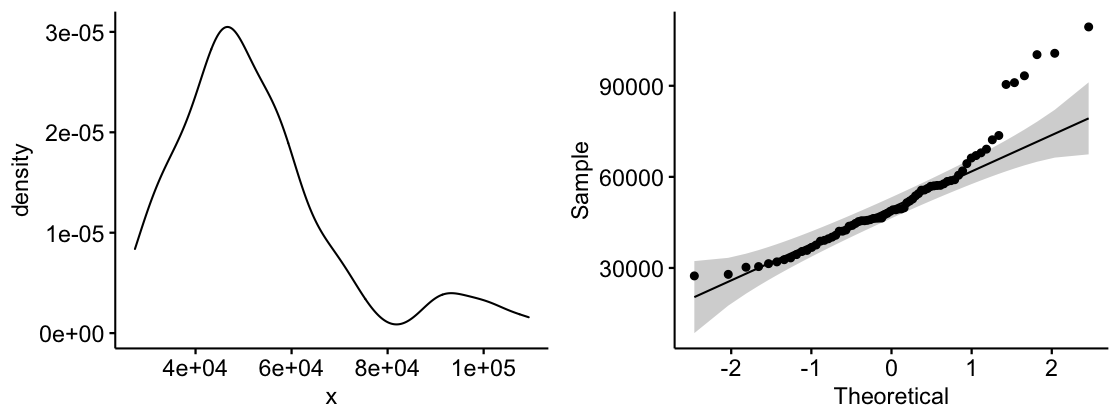

In [8]:
ggdensity(mydata_agg$TCT) -> p1
ggqqplot(mydata_agg$TCT) -> p2
grid.arrange(p1, p2, ncol = 2)

In [9]:
shapiro.test(mydata_agg$TCT)


	Shapiro-Wilk normality test

data:  mydata_agg$TCT
W = 0.887, p-value = 9.586e-06


Shapriro test is significant : the data is different from the normal distriubtion => it is not normally distributed

#### Do an log transform and check the lognormal distribution

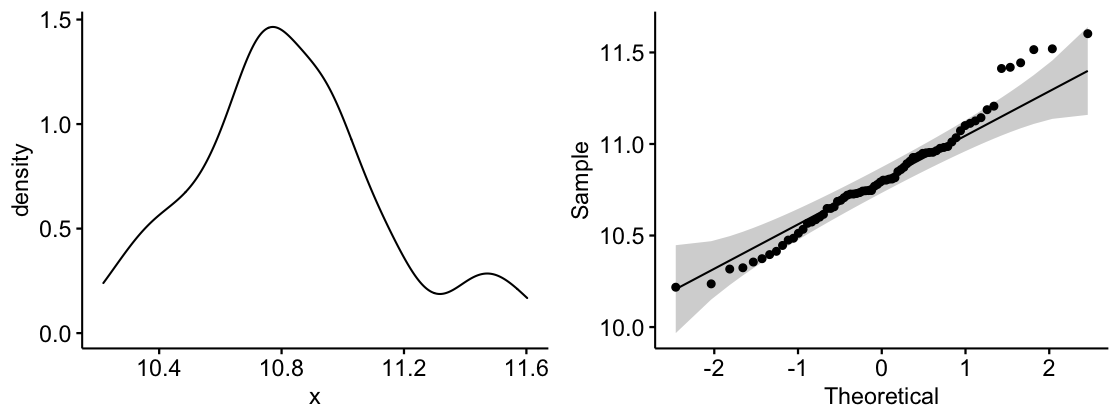

In [10]:
mydata_agg$TCT_log <- log(mydata_agg$TCT)

ggdensity(mydata_agg$TCT_log) -> p1
ggqqplot(mydata_agg$TCT_log) -> p2
grid.arrange(p1, p2, ncol = 2)

In [11]:
lillie.test(mydata_agg$TCT_log)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  mydata_agg$TCT_log
D = 0.082685, p-value = 0.2585


Kolmogorov-Smirnov test is not significant : we can assume that the data follow a lognormal distribution.  
We will analyze the TCT with a lognormal distribution

## TCT: descriptive stats and plots of the aggregated data

In [12]:
TCT_summary_agg1 <- summarySEwithin(mydata_agg, 
                                   measurevar="TCT_log", 
                                   withinvars=c("condition", "roomT"), 
                                   idvar="id")

Since we convert the data with a log transform, we need to convert them back to get the means and CIs for plots.

In [13]:
TCT_summary_agg1$TCT <- exp(TCT_summary_agg1$TCT_log)
TCT_summary_agg1$cupp <- exp(TCT_summary_agg1$TCT_log + TCT_summary_agg1$ci)
TCT_summary_agg1$clow <- exp(TCT_summary_agg1$TCT_log - TCT_summary_agg1$ci)

print(TCT_summary_agg1)

  condition roomT  N  TCT_log TCT_log_norm        sd         se        ci
1         0     0 12 11.06690     11.06690 0.2043355 0.05898656 0.1298286
2         0     1 12 10.98520     10.98520 0.2256572 0.06514161 0.1433757
3         1     0 12 10.68636     10.68636 0.1994109 0.05756497 0.1266996
4         1     1 12 10.75719     10.75719 0.2013127 0.05811397 0.1279080
5         2     0 12 10.59165     10.59165 0.2664991 0.07693166 0.1693254
6         2     1 12 10.81721     10.81721 0.2214876 0.06393797 0.1407265
       TCT     cupp     clow
1 64016.74 72891.58 56222.45
2 58994.67 68089.48 51114.66
3 43754.87 49665.10 38547.96
4 46966.59 53375.11 41327.52
5 39801.04 47144.55 33601.39
6 49871.84 57407.97 43325.01


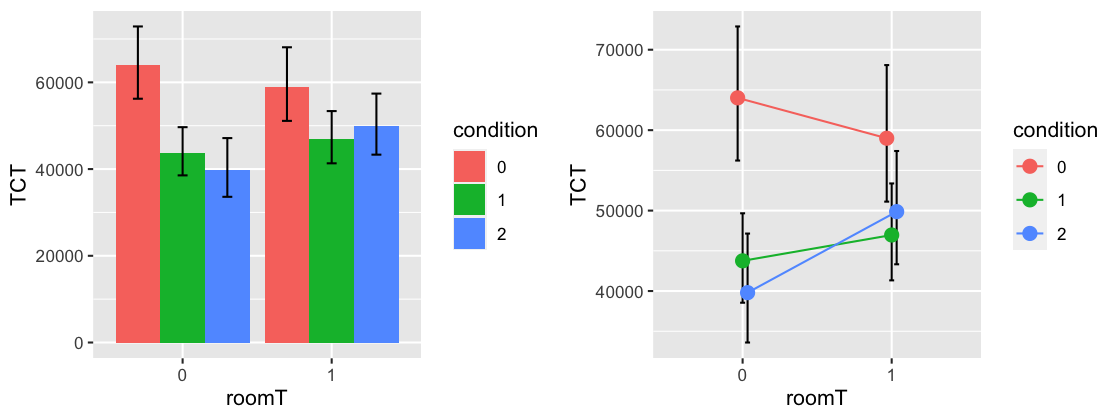

In [14]:
ggplot(TCT_summary_agg1, aes(x=roomT, y=TCT, fill=condition)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=clow, ymax=cupp),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9)) -> p1

# The errorbars overlapped, so use position_dodge to move them horizontally
pd <- position_dodge(0.1) # move them .05 to the left and right
ggplot(TCT_summary_agg1, aes(x=roomT, y=TCT, colour=condition, group=condition)) + 
    geom_errorbar(aes(ymin=clow, ymax=cupp), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3) -> p2

grid.arrange(p1, p2, ncol = 2)

## TCT: Running a Two-way repeated measure Anova

In [15]:
res_aov <- aov_ez(id = "id", dv = "TCT_log", mydata_agg, within = c("condition","roomT"))
summary(res_aov)

Warning message in summary.Anova.mlm(object$Anova, multivariate = FALSE):
“HF eps > 1 treated as 1”



Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

                Sum Sq num Df Error SS den Df    F value    Pr(>F)    
(Intercept)     8425.2      1  2.05217     11 45160.4544 < 2.2e-16 ***
condition          1.6      2  1.55984     22    11.0758 0.0004701 ***
roomT              0.1      1  0.47557     11     2.1324 0.1721794    
condition:roomT    0.3      2  0.65082     22     4.7871 0.0187925 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Mauchly Tests for Sphericity

                Test statistic p-value
condition              0.86854 0.49425
condition:roomT        0.69476 0.16187


Greenhouse-Geisser and Huynh-Feldt Corrections
 for Departure from Sphericity

                 GG eps Pr(>F[GG])    
condition       0.88381  0.0008671 ***
condition:roomT 0.76614  0.0299579 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   HF eps   Pr(>F[HF])
condition       1.0404417 0.0004701429
condition:roomT 0.8

Mauchly's Test results are not significant (condition: p = 0.49, condition X roomT: p = 0.16),  
indicating that sphericity is not violated and that an uncorrected test can be used.

Main effect of condition (F(2,22) = 11.08, p = 0.0005)  
Interaction effect of condition X roomT (F(2,22) = 4.79, p = 0.019) 

## TCT: post-hoc analysis with Tukey HSD

### Post-hoc for the main effect of condition

In [16]:
ls2 <- emmeans(res_aov, ~condition)
pairs(ls2)

NOTE: Results may be misleading due to involvement in interactions



 contrast estimate     SE df t.ratio p.value
 X0 - X1    0.3043 0.0769 22 3.958   0.0019 
 X0 - X2    0.3216 0.0769 22 4.184   0.0011 
 X1 - X2    0.0173 0.0769 22 0.226   0.9724 

Results are averaged over the levels of: roomT 
P value adjustment: tukey method for comparing a family of 3 estimates 

C0 is significantly different than C1 (p = 0.0019)  
C0 is significantly different than C2 (p = 0.0011)  
No differences between C1 and C2

### Post-hoc for the interaction effect

In [17]:
ls1 <- emmeans(res_aov, ~condition | roomT)
pairs(ls1)

roomT = X0:
 contrast estimate     SE   df t.ratio p.value
 X0 - X1    0.3805 0.0915 37.6  4.159  0.0005 
 X0 - X2    0.4753 0.0915 37.6  5.194  <.0001 
 X1 - X2    0.0947 0.0915 37.6  1.035  0.5598 

roomT = X1:
 contrast estimate     SE   df t.ratio p.value
 X0 - X1    0.2280 0.0915 37.6  2.492  0.0444 
 X0 - X2    0.1680 0.0915 37.6  1.836  0.1719 
 X1 - X2   -0.0600 0.0915 37.6 -0.656  0.7902 

P value adjustment: tukey method for comparing a family of 3 estimates 

In roomT = 0:   
C0 is significantly different than C1 (p = 0.03)  
C0 is significantly different than C2 (p = 0.021)  
No differences between C1 and C2

In roomT = 1:
C0 is significantly different than C1 (p = 0.044)  
No differences between C0 and C2, C1 and C2.

---

# Analysis of NB_Warnings

## nb_warnings: checking the distribution

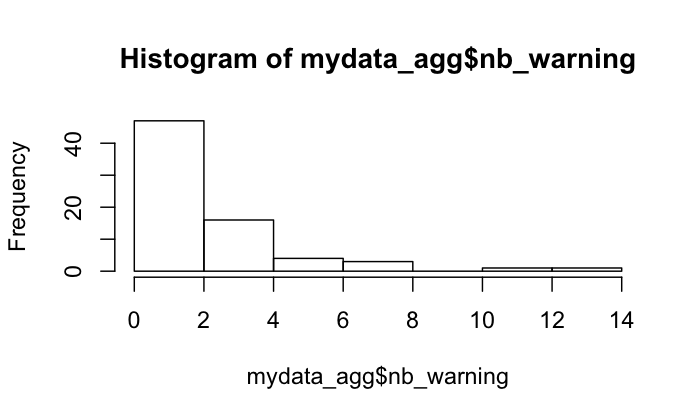

In [18]:
options(repr.plot.width = 5)
hist(mydata_agg$nb_warning)
options(repr.plot.width = 10)

nb_warnings are count data and are obvioulsy not normally distributed.  
We will use non-parametric tests on data agregated by conditions.

## nb_warnings: descriptive stats and plots of the data aggregated by condition

  condition  N nb_warning      clow     cupp
1         0 12  3.3750000 2.0416667 6.058969
2         1 12  1.5000000 0.9895833 2.177083
3         2 12  0.8958333 0.6145833 1.395833


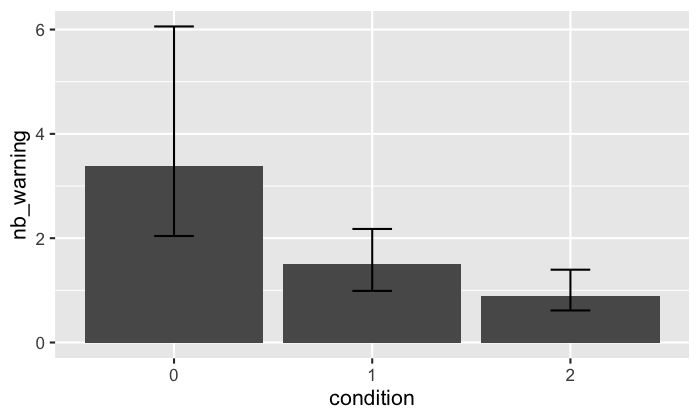

In [19]:
summary_agg3 <- summaryWithBoot(mydata_agg2, measurevar="nb_warning", groupvars=c("condition"))
print(summary_agg3)

options(repr.plot.width = 5)
ggplot(summary_agg3, aes(x=condition, y=nb_warning)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=clow, ymax=cupp),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9))
options(repr.plot.width = 10)

### nb_warnings: Friedman test on data aggregated by condition

In [20]:
friedman.test(nb_warning ~ condition | id, data=mydata_agg2 )


	Friedman rank sum test

data:  nb_warning and condition and id
Friedman chi-squared = 11.511, df = 2, p-value = 0.003165


There is a significant main effect of condition (chi-squared = 11.511, p = 0.0032)

#### Post-hoc analysis

In [21]:
pairwise.wilcox.test(mydata_agg2$nb_warning,
                     mydata_agg2$condition,
                     p.adjust.method="holm",
                     paired=T)

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”



	Pairwise comparisons using Wilcoxon signed rank test 

data:  mydata_agg2$nb_warning and mydata_agg2$condition 

  0     1    
1 0.041 -    
2 0.034 0.126

P value adjustment method: holm 

C0 is significantly different than C1 (p = 0.041)  
C0 is significantly different than C2 (p = 0.034)  
No other effects.

## nb_warning: descriptive stats and plots of the data aggregated by roomT

  roomT  N nb_warning     clow     cupp
1     0 12   1.659722 1.062500 2.638889
2     1 12   2.187500 1.395833 3.118056


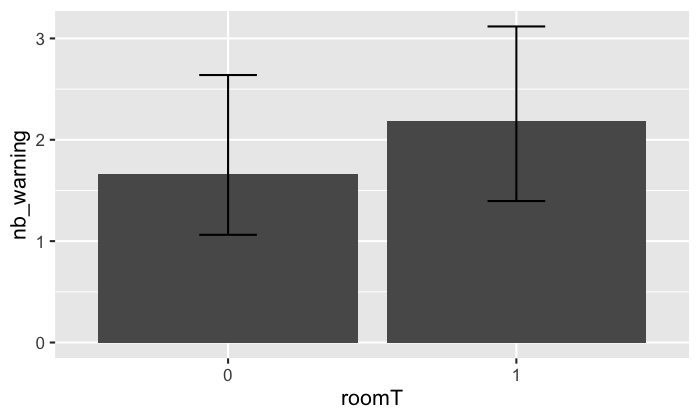

In [22]:
summary_agg5a <- summaryWithBoot(mydata_agg3, measurevar="nb_warning", groupvars=c("roomT"))
print(summary_agg5a)

options(repr.plot.width = 5)
ggplot(summary_agg5a, aes(x=roomT, y=nb_warning)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=clow, ymax=cupp),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9))
options(repr.plot.width = 10)

### nb_warnings: wilcoxon signed rank test on data aggregated by condition

In [23]:
wilcoxsign_test(nb_warning ~ roomT | id, data=mydata_agg3, dist="exact")


	Exact Wilcoxon-Pratt Signed-Rank Test

data:  y by x (pos, neg) 
	 stratified by block
Z = -1.2551, p-value = 0.2334
alternative hypothesis: true mu is not equal to 0


No effect of roomT.

## nb_warnings: descriptive stats and plots of the whole data

In [24]:
summary_agg2 <- summaryWithBoot(mydata_agg, measurevar="nb_warning", groupvars=c("condition", "roomT"))
print(summary_agg2)

  condition roomT  N nb_warning      clow      cupp
1         0     0 12  3.2916667 2.0625000 5.5000000
2         0     1 12  3.4583333 1.9583333 6.2916667
3         1     0 12  1.3541667 0.6875000 2.3125000
4         1     1 12  1.6458333 0.9583333 2.4791667
5         2     0 12  0.3333333 0.1250000 0.6458333
6         2     1 12  1.4583333 0.8958333 2.4583333


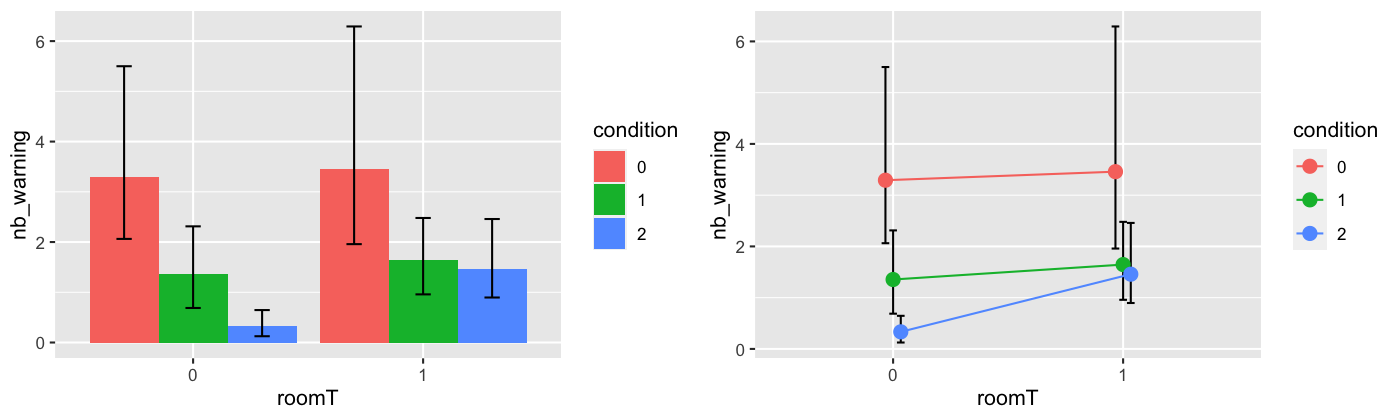

In [25]:
ggplot(summary_agg2, aes(x=roomT, y=nb_warning, fill=condition)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=clow, ymax=cupp),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9)) -> p1

# The errorbars overlapped, so use position_dodge to move them horizontally
pd <- position_dodge(0.1) # move them .05 to the left and right
ggplot(summary_agg2, aes(x=roomT, y=nb_warning, colour=condition, group=condition)) + 
    geom_errorbar(aes(ymin=clow, ymax=cupp), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3) -> p2

grid.arrange(p1, p2, ncol = 2)

### nb_warnings: Running a Friedman test on data separated by RoomT

In [26]:
roomT0 <- subset(mydata_agg, roomT == "0")
roomT1 <- subset(mydata_agg, roomT == "1")

friedman.test(nb_warning ~ condition | id, data=roomT0 )
friedman.test(nb_warning ~ condition | id, data=roomT1 )


	Friedman rank sum test

data:  nb_warning and condition and id
Friedman chi-squared = 14.279, df = 2, p-value = 0.0007931



	Friedman rank sum test

data:  nb_warning and condition and id
Friedman chi-squared = 4.9545, df = 2, p-value = 0.08397


In roomT = 0: there is a significant effect of condition (chi-squared = 14.279, p = 0.0008).   
In roomT = 1: there is no effect of condition.  
=> there is probalby an interaction effect.

#### Post-hoc analysis

In [27]:
pairwise.wilcox.test(roomT0$nb_warning,
                     roomT0$condition,
                     p.adjust.method="holm",
                     paired=T)

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”



	Pairwise comparisons using Wilcoxon signed rank test 

data:  roomT0$nb_warning and roomT0$condition 

  0     1    
1 0.029 -    
2 0.011 0.032

P value adjustment method: holm 

In RoomT = 0:  
C0 is significantly different than C1 (p = 0.029)  
C0 is significantly different than C2 (p = 0.011)  
C1 is significantly different than C2 (p = 0.032)  

---

# Analysis of NB_teleportation

## nb_teleportation: checking the distribution

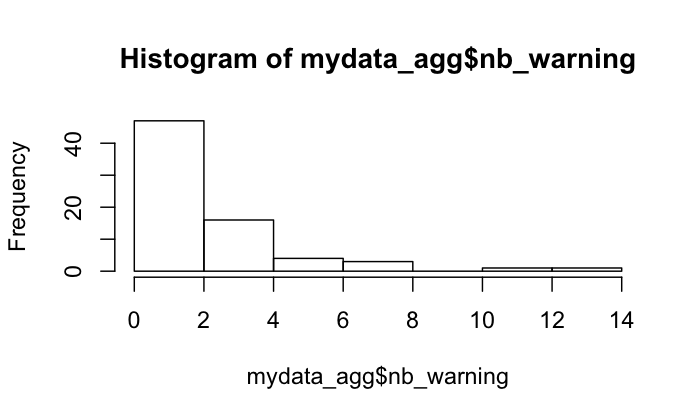

In [28]:
options(repr.plot.width = 5)
hist(mydata_agg$nb_warning)
options(repr.plot.width = 10)

nb_teleportation are count data and are obvioulsy not normally distributed.  
We will use non-parametric tests on data agregated by conditions.

## nb_teleportation: descriptive stats and plots of the data aggregated by condition

  condition  N nb_teleportation      clow      cupp
1         0 12         19.00000 13.208333 36.261595
2         1 12          3.00000  2.635417  3.604167
3         2 12          3.53125  3.072917  4.052083


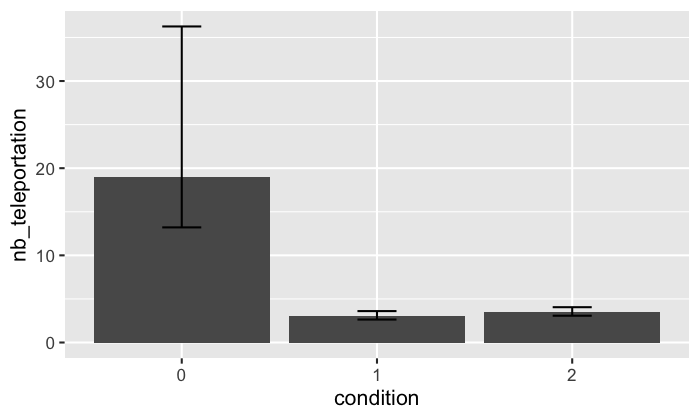

In [29]:
summary_agg5 <- summaryWithBoot(mydata_agg2, measurevar="nb_teleportation", groupvars=c("condition"))
print(summary_agg5)

options(repr.plot.width = 5)
ggplot(summary_agg5, aes(x=condition, y=nb_teleportation)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=clow, ymax=cupp),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9))
options(repr.plot.width = 10)

### nb_teleportation: Friedman test on data aggregated by condition

In [30]:
friedman.test(nb_teleportation ~ condition | id, data=mydata_agg2 )


	Friedman rank sum test

data:  nb_teleportation and condition and id
Friedman chi-squared = 19.5, df = 2, p-value = 5.829e-05


There is a significant main effect of condition (chi-squared = 19.5, p < 0.0001)

#### Post-hoc analysis

In [31]:
pairwise.wilcox.test(mydata_agg2$nb_teleportation,
                     mydata_agg2$condition,
                     p.adjust.method="holm",
                     paired=T)

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”



	Pairwise comparisons using Wilcoxon signed rank test 

data:  mydata_agg2$nb_teleportation and mydata_agg2$condition 

  0      1     
1 0.0050 -     
2 0.0015 0.1356

P value adjustment method: holm 

C0 is significantly different than C1 (p = 0.005) and C2 (p = 0.0015)  
No difference between C1 and C2

## nb_teleportation: descriptive stats and plots of the data aggregated by roomT

  roomT  N nb_teleportation     clow     cupp
1     0 12         8.611111 6.597812 14.62344
2     1 12         8.409722 6.277778 13.88406


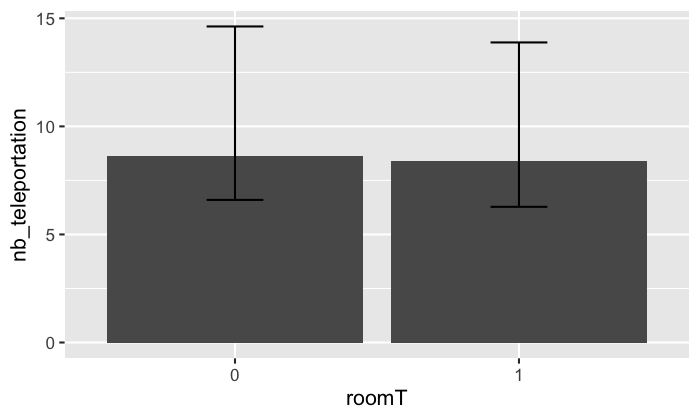

In [32]:
summary_agg5a <- summaryWithBoot(mydata_agg3, measurevar="nb_teleportation", groupvars=c("roomT"))
print(summary_agg5a)

options(repr.plot.width = 5)
ggplot(summary_agg5a, aes(x=roomT, y=nb_teleportation)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=clow, ymax=cupp),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9))
options(repr.plot.width = 10)

### nb_teleportation: wilcoxon signed rank test on data aggregated by condition

In [33]:
wilcoxsign_test(nb_teleportation ~ roomT | id, data=mydata_agg3, dist="exact")


	Exact Wilcoxon-Pratt Signed-Rank Test

data:  y by x (pos, neg) 
	 stratified by block
Z = 0.74668, p-value = 0.4814
alternative hypothesis: true mu is not equal to 0


No effect of roomT.

## nb_teleportation: descriptive stats and plots of the whole data

In [34]:
summary_agg3 <- summaryWithBoot(mydata_agg, measurevar="nb_teleportation", groupvars=c("condition", "roomT"))
print(summary_agg3)

  condition roomT  N nb_teleportation      clow      cupp
1         0     0 12        20.583333 14.520833 40.137943
2         0     1 12        17.416667 11.625000 32.968216
3         1     0 12         2.666667  2.312500  3.145833
4         1     1 12         3.333333  2.854167  4.229167
5         2     0 12         2.583333  2.250000  3.145833
6         2     1 12         4.479167  3.458333  5.687500


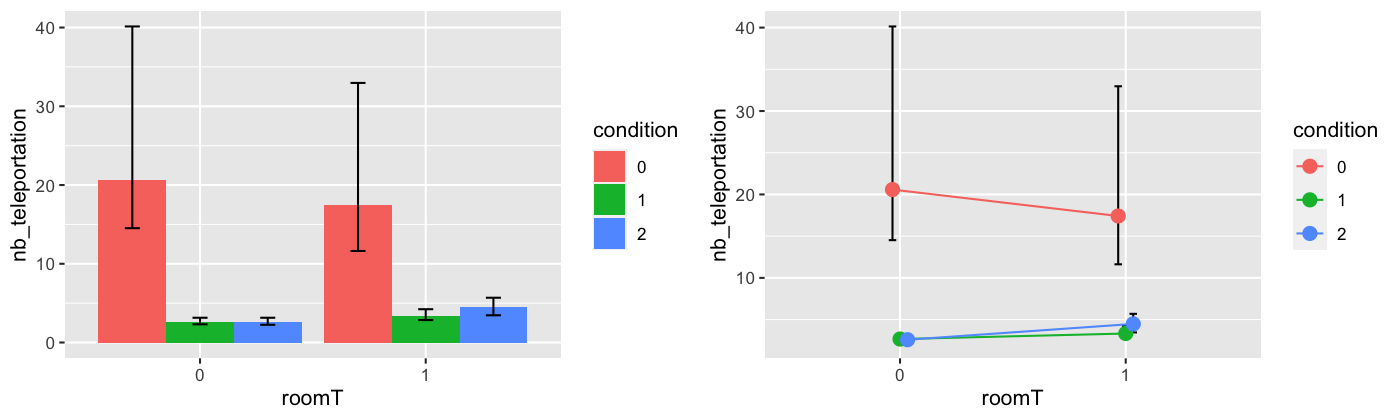

In [35]:
ggplot(summary_agg3, aes(x=roomT, y=nb_teleportation, fill=condition)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=clow, ymax=cupp),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9)) -> p1

# The errorbars overlapped, so use position_dodge to move them horizontally
pd <- position_dodge(0.1) # move them .05 to the left and right
ggplot(summary_agg3, aes(x=roomT, y=nb_teleportation, colour=condition, group=condition)) + 
    geom_errorbar(aes(ymin=clow, ymax=cupp), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3) -> p2

grid.arrange(p1, p2, ncol = 2)

### nb_teleportation: Running a Friedman test on data separated by RoomT

In [36]:
friedman.test(nb_teleportation ~ condition | id, data=roomT0 )
friedman.test(nb_teleportation ~ condition | id, data=roomT1 )


	Friedman rank sum test

data:  nb_teleportation and condition and id
Friedman chi-squared = 19.244, df = 2, p-value = 6.624e-05



	Friedman rank sum test

data:  nb_teleportation and condition and id
Friedman chi-squared = 19.447, df = 2, p-value = 5.987e-05


In roomT = 0: there is a significant effect of condition (chi-squared = 19.24, p < 0.0001).   
In roomT = 1: there is a significant effect of condition (chi-squared = 19.45, p < 0.0001).  
=> maybe no interaction effect?

#### Post-hoc analysis

In [37]:
pairwise.wilcox.test(roomT0$nb_teleportation,
                     roomT0$condition,
                     p.adjust.method="holm",
                     paired=T)

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”



	Pairwise comparisons using Wilcoxon signed rank test 

data:  roomT0$nb_teleportation and roomT0$condition 

  0      1     
1 0.0075 -     
2 0.0075 0.9039

P value adjustment method: holm 

In [38]:
pairwise.wilcox.test(roomT1$nb_teleportation,
                     roomT1$condition,
                     p.adjust.method="holm",
                     paired=T)

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with zeroes”



	Pairwise comparisons using Wilcoxon signed rank test 

data:  roomT1$nb_teleportation and roomT1$condition 

  0      1     
1 0.0015 -     
2 0.0050 0.1418

P value adjustment method: holm 

For both roomT = 0 and roomT = 1:  
C0 is significantly different than C1 (roomT = 0: p = 0.0075) and (roomT = 1: p = 0.0015)  
C0 is significantly different than C2 (roomT = 0: p = 0.0075) and (roomT = 1: p = 0.005)  
No significant difference between C1 and C2.  
=> Probably not interaction effect (only the main interaction effect on condition)

---

# Analysis of Walking

##  Walking: Checking the distribution

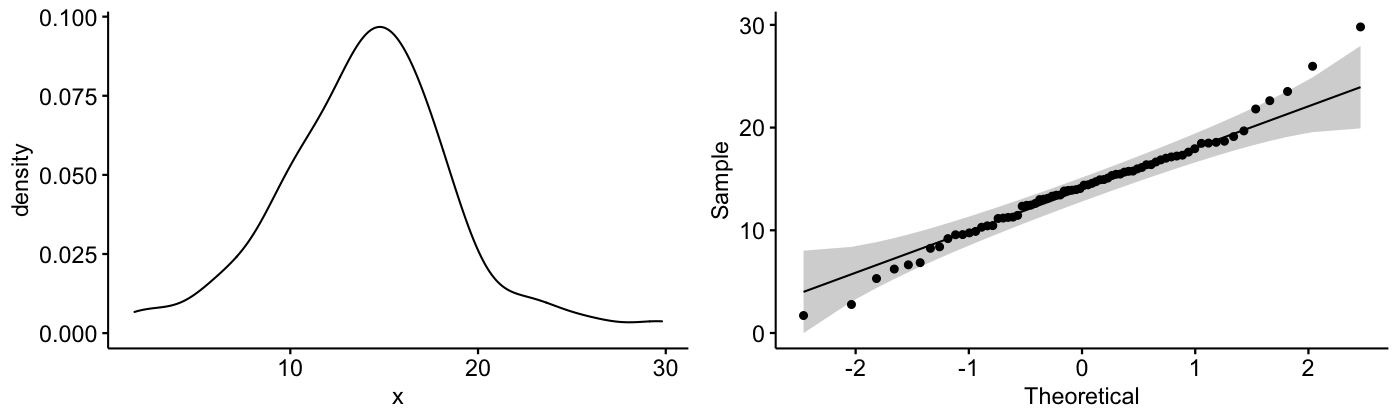

In [39]:
ggdensity(mydata_agg$walking) -> p1
ggqqplot(mydata_agg$walking) -> p2
grid.arrange(p1, p2, ncol = 2)

In [40]:
shapiro.test(mydata_agg$walking)


	Shapiro-Wilk normality test

data:  mydata_agg$walking
W = 0.9759, p-value = 0.1816


Shapriro test is not significant : the data seems normally distributed

## Walking: descriptive stats and plots of the data

In [41]:
summary_agg6 <- summarySEwithin(mydata_agg, 
                                   measurevar="walking", 
                                   withinvars=c("condition", "roomT"), 
                                   idvar="id")
print(summary_agg6)

  condition roomT  N  walking walking_norm       sd        se       ci
1         0     0 12 13.68263     13.68263 3.999368 1.1545182 2.541077
2         0     1 12 12.54952     12.54952 6.627022 1.9130565 4.210609
3         1     0 12 14.91005     14.91005 3.056102 0.8822207 1.941755
4         1     1 12 13.76130     13.76130 2.450013 0.7072579 1.556664
5         2     0 12 14.93641     14.93641 3.494809 1.0088644 2.220495
6         2     1 12 14.84418     14.84418 3.536442 1.0208830 2.246948


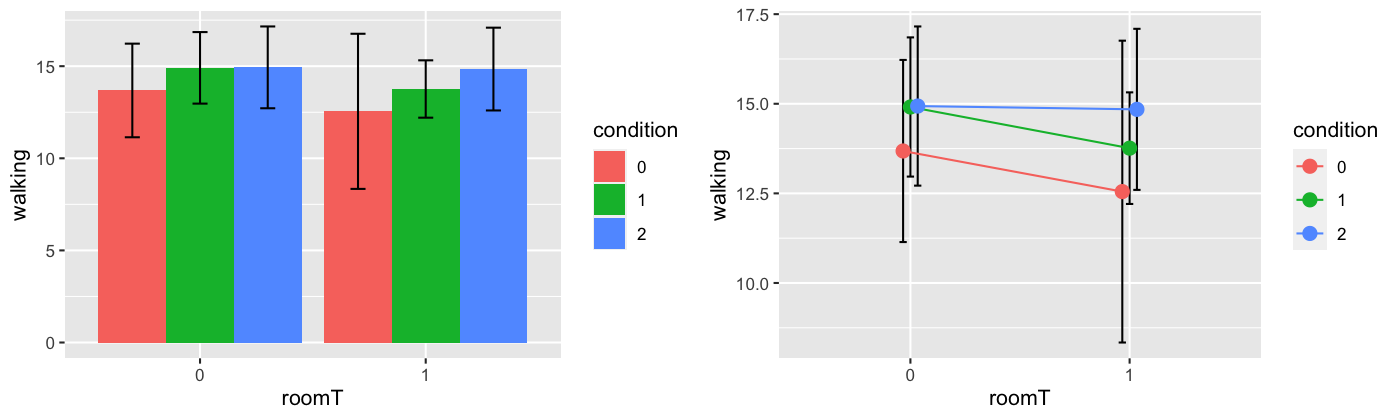

In [42]:
ggplot(summary_agg6, aes(x=roomT, y=walking, fill=condition)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=walking-ci, ymax=walking+ci),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9)) -> p1

# The errorbars overlapped, so use position_dodge to move them horizontally
pd <- position_dodge(0.1) # move them .05 to the left and right
ggplot(summary_agg6, aes(x=roomT, y=walking, colour=condition, group=condition)) + 
    geom_errorbar(aes(ymin=walking-ci, ymax=walking+ci), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3) -> p2

grid.arrange(p1, p2, ncol = 2)

## Walking: Running a Two-way repeated measure Anova

In [43]:
res_aov2 <- aov_ez(id = "id", dv = "walking", mydata_agg, within = c("condition","roomT"))
summary(res_aov2)


Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

                 Sum Sq num Df Error SS den Df  F value    Pr(>F)    
(Intercept)     14342.8      1   680.91     11 231.7067 9.763e-09 ***
condition          39.5      2   607.07     22   0.7165    0.4995    
roomT              11.3      1   153.55     11   0.8075    0.3881    
condition:roomT     4.4      2   155.81     22   0.3106    0.7361    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Mauchly Tests for Sphericity

                Test statistic  p-value
condition              0.23105 0.000658
condition:roomT        0.56427 0.057203


Greenhouse-Geisser and Huynh-Feldt Corrections
 for Departure from Sphericity

                 GG eps Pr(>F[GG])
condition       0.56531     0.4302
condition:roomT 0.69651     0.6594

                   HF eps Pr(>F[HF])
condition       0.5860221  0.4345933
condition:roomT 0.7659106  0.6797188

Mauchly's Test results are significant for condition: p = 0.0007, indicating that sphericity is violated and that the corrected p-value (p\[GG\]) must be used (Greenhouse-Geisser correction).  
=> No significant effects detected.

---

# Analysis of Rotation

##  Rot: Checking the normal distribution

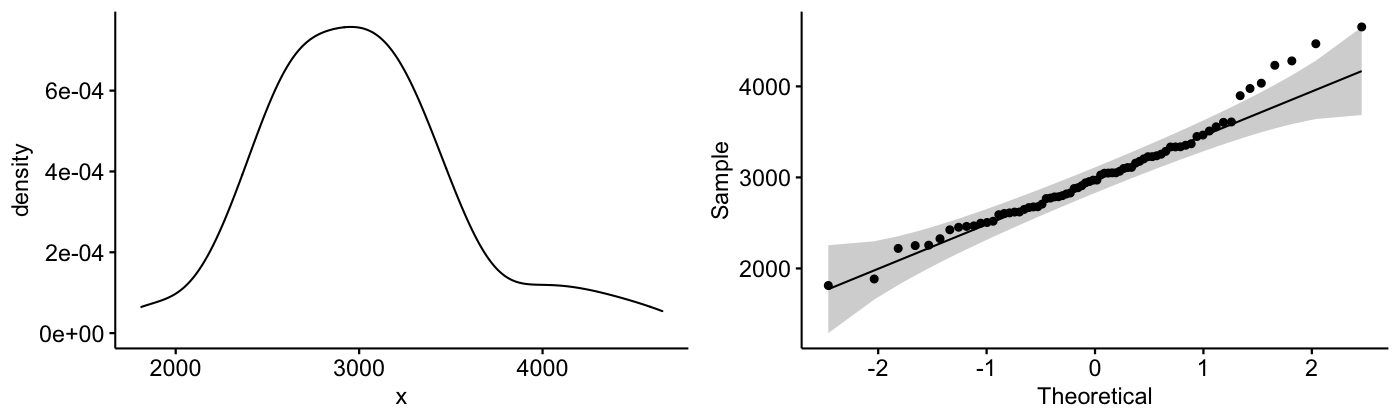

In [44]:
ggdensity(mydata_agg$rot) -> p1
ggqqplot(mydata_agg$rot) -> p2
grid.arrange(p1, p2, ncol = 2)

In [45]:
shapiro.test(mydata_agg$rot)


	Shapiro-Wilk normality test

data:  mydata_agg$rot
W = 0.96379, p-value = 0.03628


Shapriro test is significant : the data is different from the normal distriubtion => it is not normally distributed

#### Do an log transform and check the lognormal distribution

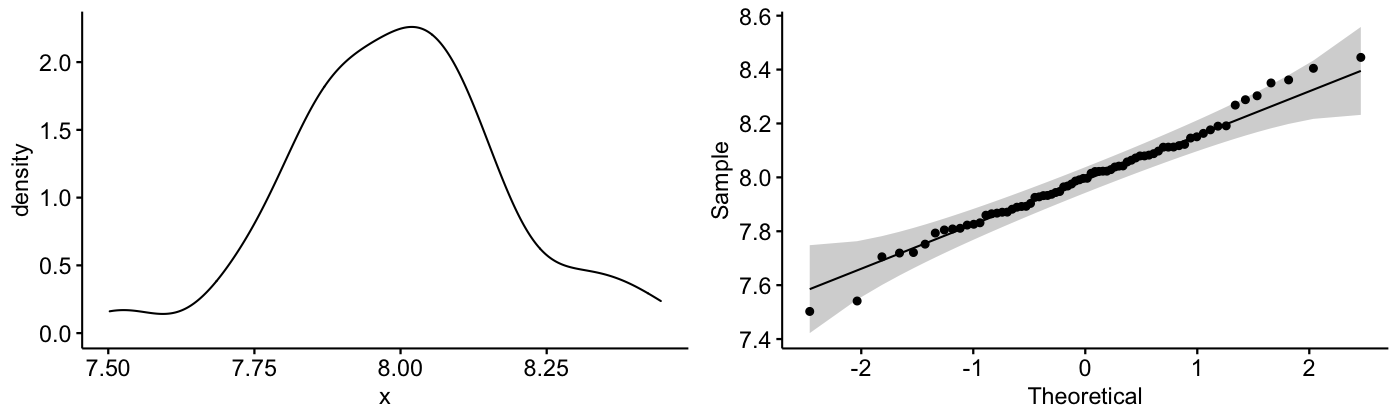

In [46]:
mydata_agg$rot_log <- log(mydata_agg$rot)

ggdensity(mydata_agg$rot_log) -> p1
ggqqplot(mydata_agg$rot_log) -> p2
grid.arrange(p1, p2, ncol = 2)

In [47]:
lillie.test(mydata_agg$rot_log)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  mydata_agg$rot_log
D = 0.063703, p-value = 0.6663


Kolmogorov-Smirnov test is not significant : we can assume that the data follow a lognormal distribution.  
We will analyze the TCT with a lognormal distribution

## Rot: descriptive stats and plots of the aggregated data

In [48]:
summary_agg7 <- summarySEwithin(mydata_agg, 
                                   measurevar="rot_log", 
                                   withinvars=c("condition", "roomT"), 
                                   idvar="id")

In [49]:
summary_agg7$rot <- exp(summary_agg7$rot_log)
summary_agg7$cup <- exp(summary_agg7$rot_log + summary_agg7$ci)
summary_agg7$clo <- exp(summary_agg7$rot_log - summary_agg7$ci)

print(summary_agg7)

  condition roomT  N  rot_log rot_log_norm        sd         se         ci
1         0     0 12 8.130374     8.130374 0.1519071 0.04385180 0.09651715
2         0     1 12 8.071336     8.071336 0.1525056 0.04402458 0.09689745
3         1     0 12 7.945007     7.945007 0.1350776 0.03899356 0.08582424
4         1     1 12 7.895838     7.895838 0.1527473 0.04409434 0.09705098
5         2     0 12 7.960586     7.960586 0.1058159 0.03054642 0.06723222
6         2     1 12 7.975882     7.975882 0.1022643 0.02952117 0.06497566
       rot      cup      clo
1 3396.068 3740.186 3083.610
2 3201.376 3527.108 2905.726
3 2821.453 3074.297 2589.404
4 2686.080 2959.836 2437.644
5 2865.751 3065.046 2679.414
6 2909.923 3105.275 2726.861


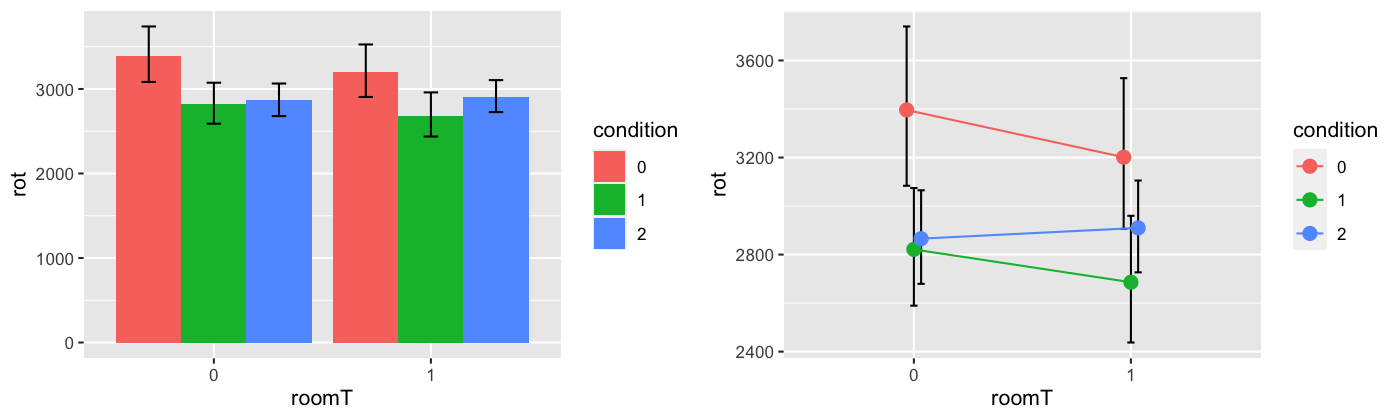

In [50]:
ggplot(summary_agg7, aes(x=roomT, y=rot, fill=condition)) +
geom_bar(stat="identity", position=position_dodge()) +
geom_errorbar(aes(ymin=clo, ymax=cup),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9)) -> p1

# The errorbars overlapped, so use position_dodge to move them horizontally
pd <- position_dodge(0.1) # move them .05 to the left and right
ggplot(summary_agg7, aes(x=roomT, y=rot, colour=condition, group=condition)) + 
    geom_errorbar(aes(ymin=clo, ymax=cup), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3) -> p2

grid.arrange(p1, p2, ncol = 2)

## Rot: Running a Two-way repeated measure Anova

In [51]:
res_aov3 <- aov_ez(id = "id", dv = "rot_log", mydata_agg, within = c("condition","roomT"))
summary(res_aov3)

Warning message in summary.Anova.mlm(object$Anova, multivariate = FALSE):
“HF eps > 1 treated as 1”



Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

                Sum Sq num Df Error SS den Df    F value    Pr(>F)    
(Intercept)     4604.0      1  0.88572     11 57178.0759 < 2.2e-16 ***
condition          0.4      2  0.53786     22     8.5782  0.001761 ** 
roomT              0.0      1  0.23650     11     0.8030  0.389382    
condition:roomT    0.0      2  0.23000     22     0.9353  0.407510    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Mauchly Tests for Sphericity

                Test statistic p-value
condition              0.92922 0.69277
condition:roomT        0.97485 0.88041


Greenhouse-Geisser and Huynh-Feldt Corrections
 for Departure from Sphericity

                 GG eps Pr(>F[GG])   
condition       0.93390   0.002303 **
condition:roomT 0.97547   0.405756   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                  HF eps  Pr(>F[HF])
condition       1.117668 0.001761282
condition:roomT 1.183059 0

Mauchly's Test results are not significant (condition: p = 0.69, condition X roomT: p = 0.88),  
indicating that sphericity is not violated and that an uncorrected test can be used.

Main effect of condition (F(2,22) = 8.58, p = 0.0018)  
No effect of roomT and no interaction effect. 

## Rot: post-hoc analysis

#### Post-hoc for the main effect of condition with Tukey HSD

In [52]:
ls3 <- emmeans(res_aov3, ~condition)
pairs(ls3)

NOTE: Results may be misleading due to involvement in interactions



 contrast estimate     SE df t.ratio p.value
 X0 - X1    0.1804 0.0451 22  3.997  0.0017 
 X0 - X2    0.1326 0.0451 22  2.938  0.0200 
 X1 - X2   -0.0478 0.0451 22 -1.059  0.5486 

Results are averaged over the levels of: roomT 
P value adjustment: tukey method for comparing a family of 3 estimates 

C0 is significantly different than C1 (p = 0.0017)  
C0 is significantly different than C2 (p = 0.02)  
No differences between C1 and C2